# Dillard's

In [116]:
# Import libraries
import pandas as pd
# import numpy as np
# from matplotlib import pyplot

In [117]:
df_Data = pd.read_csv("./ConsolidatedData.csv")
# Due to shortage of time all the data massaging and manipulation was done using sql server after importing data into the 
    # sql server. Then a csv file was created from the resultant consolidation. I could have used pandas and df
# The original data had the following set of individual data sets:
#     1. customer.txt - 25000 Records
#     2. customer_email_campaign_agg.txt ~22000
#     3. customer_subscription_status.txt
#     4. item.txt -- This data was ignored since this is just a list of items offered at Dillards. There's (seems to be) no connection with the model for this.
#     5. store_location.txt -- Locations of Dillard's stores
#     6. transaction_detail.txt -- Line item transactions of each customer. One-to-many relationship
# Observations:
#     1. There was a big mismatch of customer id's between customer_email_campaign_agg.txt and the rest of the data sets.
#     2. Out 25k records in Customer and 22k records in customer_email_campaign_agg.txt only 1003 records mathc. According to
#         Ambex this was a sampling error so I decided to work with 1003 records in order to have a sane model.
#     3. I realize its a tiny subset of the overall data but I figured since it was a sampling error otherwise I'd have more 
#         matching data.
#     4. This may not produce the best accuracy score but at least it would allow me to create a reliable model.

In [118]:
df_Data.head()
# Feature Engineering:
#     1. Data from the transactional details dataset was aggregated(summed) into a single line for each customer.
#     All times were aggregated into sum of the count of inidividual items. This was to see how many varieties of items are 
#         customers buying.
#     NetSpend amount was summed up to get a nice one-to-one matching per customer
#     2. There was an interesting observation for some customers regarding the locations. Some customer used multiple locations
#     spread across several states. It's assumed that these might be commercial customers with offices in several locations or
#     traveling consultants who probably have a Dillard's card issued by their employers.
#     I added up the count of Distinct locations complimented by distinct cities and distinct state counts to give the locations
#     a more meaningful explanations.

,customer_id,DistinctItems,DistinctLocations,NetSpend,DistinctCity,DistinctState,customer_contact_acquisition_date,household_has_dillards_credit_card,unsubscribed_yn,total_email_sent_count,total_email_open_count,total_email_click_count,product_email_sent_count,product_email_open_count,product_email_click_count,sale_email_sent_count,sale_email_open_count,sale_email_click_count,last_email_open_date,last_email_click_date
0,127856778,51,6,2235.91,5,2,5/1/1980,Y,Y,2,1,1,1,0,0,1,1,1,6/27/2018,6/27/2018
1,226337288,11,2,714.50,2,2,6/24/2018,N,Y,2,2,0,1,1,0,1,1,0,6/30/2018,NaN
2,226356831,3,1,536.00,1,1,6/26/2018,N,Y,2,2,0,1,1,0,1,1,0,6/30/2018,NaN
3,185480119,10,1,445.74,1,1,1/1/2009,N,Y,2,2,2,1,1,1,1,1,1,6/30/2018,6/30/2018
4,201550421,9,2,373.99,2,1,3/21/2013,N,Y,3,3,3,1,1,1,1,1,1,7/1/2018,7/1/2018


Feautre Engineering to further compact the data:
    1. customer_contact_acquisition_date field will have very little meaning if its left in the date field. I will subtract
    the date from current/system date to get an integer that will be more meaningful for the model to work with.
    2. Fields 'total_email_sent_count', 'total_email_open_count', 'total_email_click_count' are related fields. They might
    give the model a severe case of multicolinearity so I will consolidate the three fields.
    - Field 'total_email_click_count' seems redundant so it will be omitted.
    - Field total_email_open_count will be divided by total_email_sent_count and rounded to generate an integer to create a 
    new field called 'total_email_read_Percent'. Now the model has workable data.
    3. Fields 'product_email_sent_count', 'product_email_open_count', 'product_email_click_count' will be dealt with the same
    way as #2 above
    4. Fields 'sale_email_sent_count', 'sale_email_open_count', 'sale_email_click_count' will also be dealt with the same
    was as #2, #3 above.
    5. unsubscribed_yn field will be changed to reflect the same meaning but in an opposite way by changing the name to
    Subsribed so that Y = 1 and N = 0 when we do get_dummies.
    6. 'last_email_open_date', 'last_email_click_date' are deemed unnecessary (based on common sense) for modeling purposes.
    7. Upon closer look it is pretty obvious that column 'total_email_sent_count' = product_emails + sale_emails + other_emails
    Therefore to avoid multicolinearity, the columns related to product_emails and sales_emails will be removed and just the
    total_emails column will be used as its all inclusive.
    6. Assumptions:
        i. Null fields in product_emails_sent and sale_emails_sent were set to 0 since their corresponding fields were also 0
        ii. The null fields in NetSpend column has been set to 0. It is assumed that if the total number transactions are 
        ZERO then the customer didn't have any sales that would generate sales data.

In [121]:
df_FinalData = pd.read_csv("./FinalData.csv")

In [122]:
# df_FinalData.sort_values(by='NetSpend', ascending=False)
df_FinalData.head()

,customerId,DistinctItems,DistinctLocs,NetSpend,DistinctCities,DistinctState,DaysSinceCustContact,dillards_crd,total_email_sent_count,t_email_read_Percent,Subscribed
0,115626867,5,1,182.14,1,1,6470,Y,48,27,N
1,115696215,17,1,479.24,1,1,6470,Y,55,2,N
2,115822340,11,1,485.25,1,1,6470,N,50,100,N
3,115823054,15,1,363.26,1,1,6470,Y,45,58,N
4,115856495,5,1,302.98,1,1,6470,N,44,0,N


In [123]:
import seaborn as sns
sns.set(font_scale=2, style="ticks", color_codes=True)
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

Percentage of 'NO' Subscription is 84.94516450648057
Percentage of Subscription 15.054835493519441
N    852
Y    151
Name: Subscribed, dtype: int64
There seems to be a class imbalance


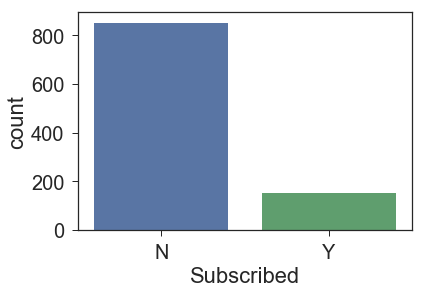

In [124]:
# Checking the imbalance of the data
df_FinalData['Subscribed'].value_counts()
count_no_sub = len(df_FinalData[df_FinalData['Subscribed']=='N'])
count_sub = len(df_FinalData[df_FinalData['Subscribed']=='Y'])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("Percentage of 'NO' Subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("Percentage of Subscription", pct_of_sub*100)
print(df_FinalData['Subscribed'].value_counts())
sns.countplot(x= 'Subscribed', data=df_FinalData) #, palette = 'his')
# plt.show()
# plt.savefig('Counts_Plot')

if (abs(count_no_sub - count_sub)) >20:
    print("There seems to be a class imbalance")
else:
    print("The classes are balanced good enough to model without oversampling.")

Text(0,0.5,'Subscribed')

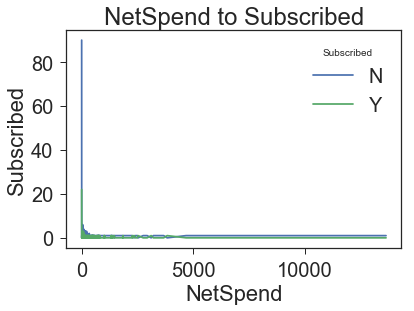

In [125]:
%matplotlib inline
pd.crosstab(df_FinalData.NetSpend,df_FinalData.Subscribed).plot()
# pd.crosstab(df_FinalData.NetSpend,df_FinalData.Subscribed).plot(kind='bar')
plt.title('NetSpend to Subscribed')
plt.xlabel('NetSpend')
plt.ylabel('Subscribed')
# plt.savefig('purchase_fre_job')

Text(0,0.5,'Subscribed')

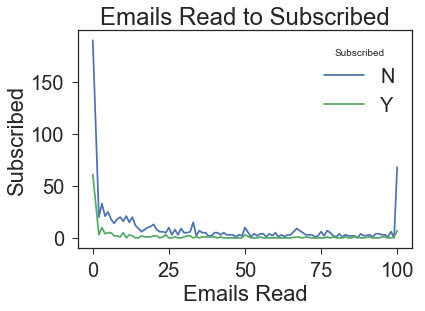

In [126]:
%matplotlib inline
pd.crosstab(df_FinalData.t_email_read_Percent,df_FinalData.Subscribed).plot()
# pd.crosstab(df_FinalData.NetSpend,df_FinalData.Subscribed).plot(kind='bar')
plt.title('Percent Emails Read to Subscribed')
plt.xlabel('Percent Emails Read')
plt.ylabel('Subscribed')
# plt.savefig('purchase_fre_job')

Text(0,0.5,'Subscribed')

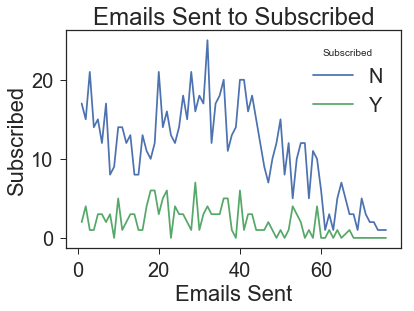

In [127]:
%matplotlib inline
pd.crosstab(df_FinalData.total_email_sent_count,df_FinalData.Subscribed).plot()
# pd.crosstab(df_FinalData.NetSpend,df_FinalData.Subscribed).plot(kind='bar')
plt.title('Emails Sent to Subscribed')
plt.xlabel('Emails Sent')
plt.ylabel('Subscribed')
# plt.savefig('purchase_fre_job')

Text(0,0.5,'Subscribed')

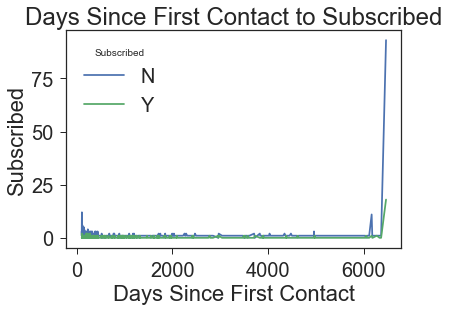

In [128]:
%matplotlib inline
pd.crosstab(df_FinalData.DaysSinceCustContact,df_FinalData.Subscribed).plot()
# pd.crosstab(df_FinalData.NetSpend,df_FinalData.Subscribed).plot(kind='bar')
plt.title('Days Since First Contact to Subscribed')
plt.xlabel('Days Since First Contact')
plt.ylabel('Subscribed')
# plt.savefig('purchase_fre_job')

Text(0,0.5,'Subscribed')

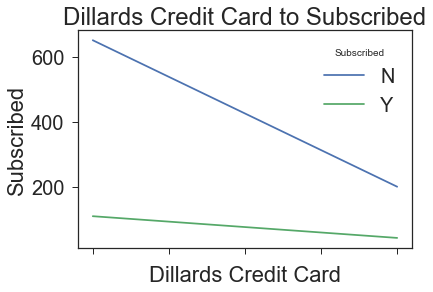

In [129]:
%matplotlib inline
pd.crosstab(df_FinalData.dillards_crd,df_FinalData.Subscribed).plot()
# pd.crosstab(df_FinalData.NetSpend,df_FinalData.Subscribed).plot(kind='bar')
plt.title('Dillards Credit Card to Subscribed')
plt.xlabel('Dillards Credit Card')
plt.ylabel('Subscribed')
# plt.savefig('purchase_fre_job')

Text(0,0.5,'Proportion of Subscribed')

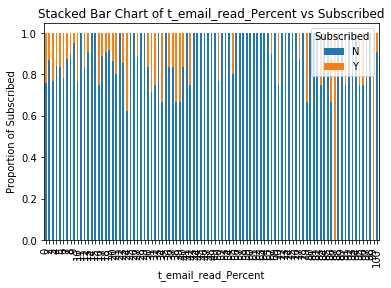

In [27]:
table=pd.crosstab(df_FinalData.t_email_read_Percent,df_FinalData.Subscribed)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of t_email_read_Percent vs Subscribed')
plt.xlabel('t_email_read_Percent')
plt.ylabel('Proportion of Subscribed')
# plt.savefig('xx')

In [13]:
# df_FinalData['DistinctLocs'].unique() # Get unique values in any particular column for understanding data
# The result will be an array

In [ ]:
# STARTING MODELING

In [91]:
# Modeling with data using 1's and 0's for nan parametric boolean columns instead of one hot encoding. We'll do the get+dummies below
import pandas as pd
df_AllNumeric = pd.read_csv('FinalData_AllNumeric.csv')
df_AllNumeric.drop(['customerId'],axis=1,inplace=True)
df_AllNumeric.columns

Index(['DistinctItems', 'DistinctLocs', 'NetSpend', 'DistinctCities',
       'DistinctState', 'DaysSinceCustContact', 'dillards_crd',
       't_email_read_Percent', 'Subscribed'],
      dtype='object')

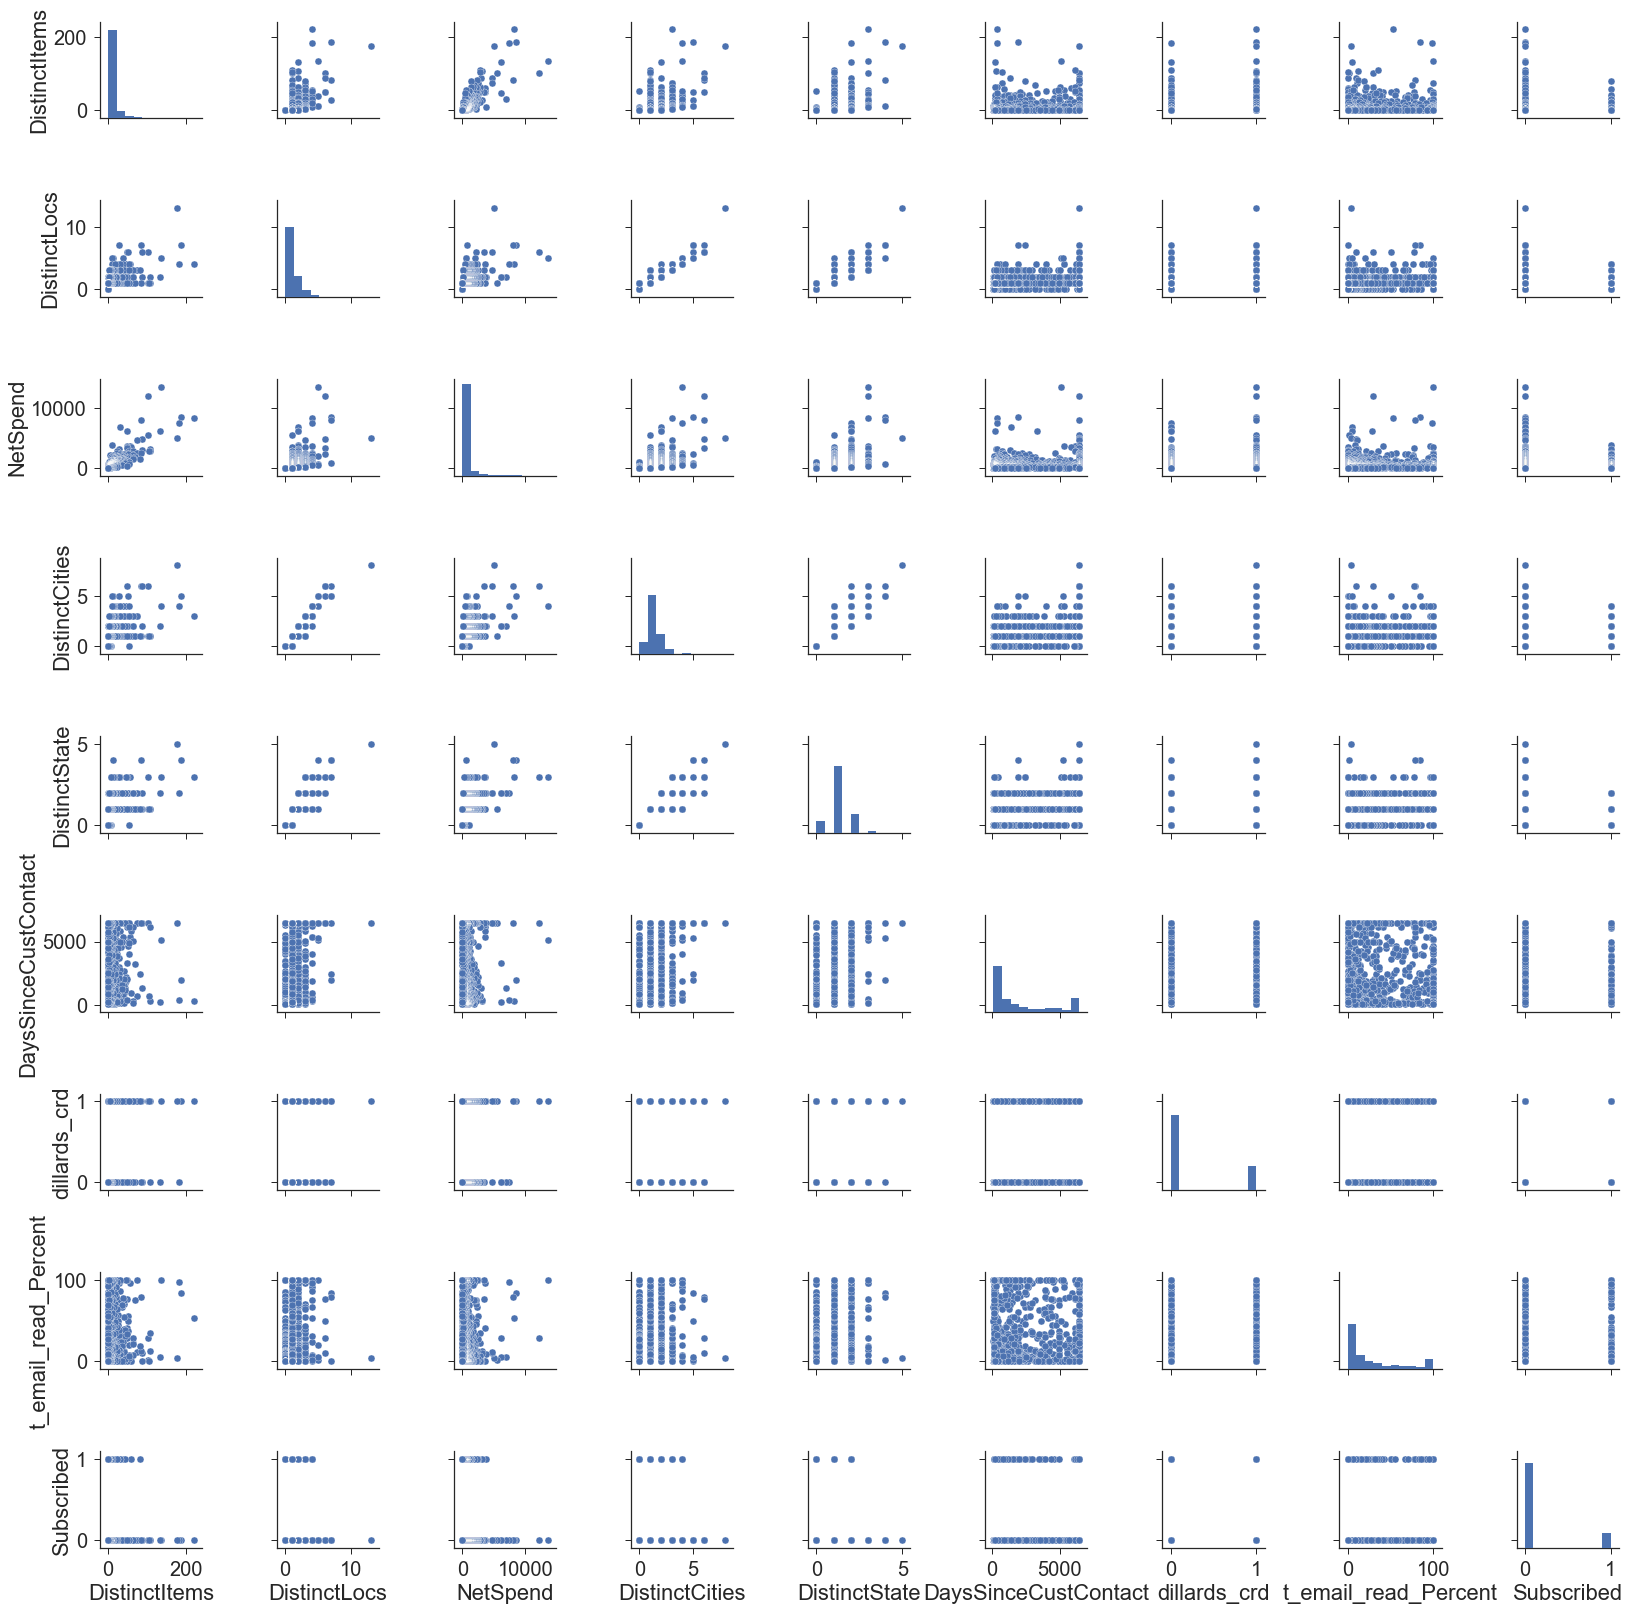

In [92]:
sns.pairplot(df_AllNumeric)

In [93]:
from sklearn.model_selection import train_test_split
X = df_AllNumeric[['DistinctItems', 'DistinctLocs', 'NetSpend',
       'DistinctCities', 'DistinctState', 'DaysSinceCustContact',
       'dillards_crd', 't_email_read_Percent']]
# X = df_AllNumeric[['customerId', 'DistinctItems', 'DistinctLocs', 'NetSpend',
#        'DistinctCities', 'DistinctState', 'DaysSinceCustContact',
#        'dillards_crd', 't_email_read_Percent']]

y = df_AllNumeric['Subscribed']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = 42)

In [94]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

# The p-values for some of the variables are smaller than 0.0. we will remove them.

Optimization terminated successfully.
         Current function value: 0.420895
         Iterations 7
                           Results: Logit
Model:                 Logit             Pseudo R-squared:  0.007   
Dependent Variable:    Subscribed        AIC:               860.3144
Date:                  2018-10-05 12:05  BIC:               899.6004
No. Observations:      1003              Log-Likelihood:    -422.16 
Df Model:              7                 LL-Null:           -424.93 
Df Residuals:          995               LLR p-value:       0.59367 
Converged:             1.0000            Scale:             1.0000  
No. Iterations:        7.0000                                       
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
DistinctItems        -0.0084   0.0125 -0.6786 0.4974 -0.0329  0.0160
DistinctLocs         -0.0223

In [95]:
# Using Logistic regression without Standard Scaler
from sklearn.linear_model import LogisticRegression
# from sklearn import metrics
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) #Already done above
logregNoSS = LogisticRegression()
logregNoSS.fit(X_train, y_train)
logregNoSS.score(X_test,y_test)

0.8471760797342193

In [96]:
# Using Logistic regression WITH Standard Scaler
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = 42) #Already done above
X_train_S = SS.fit_transform(X_train)
X_test_S = SS.transform(X_test)

In [97]:
# Using Logistic regression WITH Standard Scaler
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_S, y_train)
logreg.score(X_test_S,y_test)
# LogReg.predict_proba()

0.8471760797342193

In [98]:
# Using KNN WITH Standard Scaler
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_S, y_train)
knn.score(X_test_S,y_test)
# LogReg.predict_proba()

0.8205980066445183

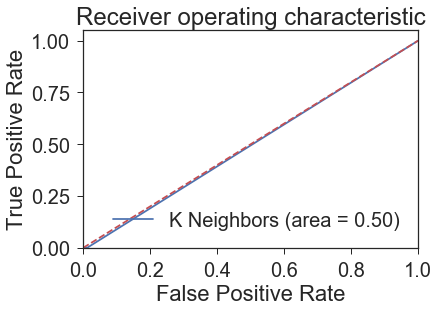

In [102]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='K Neighbors (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('KNN_ROC')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


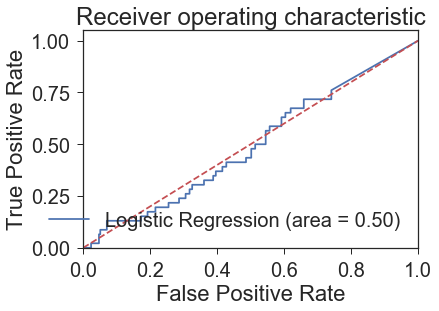

In [99]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [101]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
y_pred = knn.predict(X_test)
print('Accuracy of K Neighbors classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.85
Accuracy of K Neighbors classifier on test set: 0.85


In [28]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix = confusion_matrix(y_test, y_pred)
# # confusion_matrix
# print(confusion_matrix)

[[  0 255]
 [  0  46]]


In [107]:
from sklearn.metrics import mean_squared_error
import numpy as np

LR_y_pred = logreg.predict(X_test_S)
KNN_y_pred = knn.predict(X_test_S)
# RF_y_pred = RFR.predict(X_test_S)

print('LogReg Train',np.sqrt(mean_squared_error(y_train, logreg.predict(X_train_S))))
print('KNN Train',np.sqrt(mean_squared_error(y_train, knn.predict(X_train_S))))
# print('LR Train',np.sqrt(mean_squared_error(y_train, RFR.predict(X_train_S))))

print('LogReg Test',np.sqrt(mean_squared_error(y_test, LR_y_pred)))
print('KNN Test',np.sqrt(mean_squared_error(y_test, KNN_y_pred)))
# print('LR Train',np.sqrt(mean_squared_error(y_test, RF_y_pred)))

LogReg Train 0.3867462340768809
KNN Train 0.3540566696958629
LogReg Test 0.39092700119815305
KNN Test 0.4235587248015105


In [36]:
# Testing other models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC #SupportVectorClassifier

from sklearn.model_selection import train_test_split


methods = [KNeighborsClassifier, DecisionTreeClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, LinearSVC]

for method in methods:
    instance = method()
    model = instance.fit(X, y)
    print("Method:", method)
    print("Score:", model.score(X, y))
    print("-------------")

Method: <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Score: 0.8504486540378864
-------------
Method: <class 'sklearn.tree.tree.DecisionTreeClassifier'>
Score: 1.0
-------------
Method: <class 'sklearn.ensemble.bagging.BaggingClassifier'>
Score: 0.9770687936191426
-------------
Method: <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>
Score: 0.8484546360917248
-------------
Method: <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
Score: 0.8963110667996012
-------------
Method: <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Score: 0.9750747756729811
-------------
Method: <class 'sklearn.svm.classes.LinearSVC'>
Score: 0.15054835493519442
-------------


In [85]:
# Making actual Predictions
df_AllNumericPredict = pd.read_csv('FinalData_AllNumericPredict.csv')
df_AllNumericPredict.head()

,customerId,DistinctItems,DistinctLocs,NetSpend,DistinctCities,DistinctState,DaysSinceCustContact,dillards_crd,t_email_read_Percent,Subscribed
0,115626867,5,1,182.14,1,1,6470,1,27,0
1,115696215,17,1,479.24,1,1,6470,1,2,0
2,115822340,11,1,485.25,1,1,6470,0,100,0
3,115823054,15,1,363.26,1,1,6470,1,58,0
4,115856495,5,1,302.98,1,1,6470,0,0,0


In [86]:
X_Predict = df_AllNumericPredict[[ 'DistinctItems', 'DistinctLocs', 'NetSpend',
       'DistinctCities', 'DistinctState', 'DaysSinceCustContact',
       'dillards_crd', 't_email_read_Percent']]
y_predict = df_AllNumericPredict['Subscribed']

In [57]:
df_Predict = pd.DataFrame()

In [80]:
series_predict = knn.predict(X_Predict)
df_Predict['Subscribe'] = pd.Series(series_predict)

In [77]:
print(knn.predict(X_Predict))
# print(knn.predict_proba(X_Predict))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


In [78]:
df_Predict['customerId'] = df_AllNumericPredict['customerId']

In [81]:
df_Predict[['customerId', 'Subscribe']].to_csv('submissionAllNumeric.csv', index=False)# you dont need index else it messes up the submission

In [ ]:
#---------------Modeling with one hot encoding

In [114]:
df_with_dummies = pd.get_dummies( df_FinalData, columns = ['dillards_crd'] )
df_with_dummies.head()

,customerId,DistinctItems,DistinctLocs,NetSpend,DistinctCities,DistinctState,DaysSinceCustContact,t_email_read_Percent,Subscribed,dillards_crd_N,dillards_crd_Y
0,220362069,0,0,0.0,0,0,676,100,N,1,0
1,225692457,0,0,0.0,0,0,167,100,N,0,1
2,226360887,0,0,0.0,0,0,99,100,N,1,0
3,165172588,0,0,0.0,0,0,4619,100,Y,0,1
4,219602070,0,0,0.0,0,0,749,100,Y,1,0


In [ ]:
# ---------------OVERSAMPLING TESTING---------------------------

In [71]:
# Implementing SMOTE to counter class imbalance
X = df_AllNumeric.loc[:, df_AllNumeric.columns != 'Y']
y = df_AllNumeric.loc[:, df_AllNumeric.columns == 'Y']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(Xgd_train, ygd_train)#(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
# os_data_y= pd.DataFrame(data=os_data_y,columns=['Y'])
# # we can Check the numbers of our data
# print("length of oversampled data is ",len(os_data_X))
# print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
# print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
# print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
# print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

ValueError: Shape of passed values is (6, 1194), indices imply (10, 1194)